In [1]:
import os, sys, json, time, re
import random, collections, cPickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pickle
sys.path.append('/Users/matt.meng/dev/seq2seq_model/')
from data_preprocess import tokenize_title_column, create_vocab_dict
%matplotlib inline  

In [2]:
data_path = '/Users/matt.meng/title_data.csv'

In [3]:
#data = pd.read_csv(data_path, delimiter='\t')
data = pd.read_csv(data_path, index_col='url', delimiter='\t')

In [4]:
print data.shape
data.head()


(464340, 2)


,title,traffic
url,,
https://www.bizjournals.com/sanfrancisco/news/2017/07/21/mission-san-francisco-real-estate-elon-musk.html,"Bridgeton Holdings sold the Pioneer Building, ...",577.0
https://www.bizjournals.com/sanfrancisco/news/2017/07/24/real-estate-fintech-opendoor-florida-expansion.html,San Francisco real estate fintech Opendoor hir...,379.0
https://www.bizjournals.com/chicago/news/2017/07/25/united-airlines-special-for-boeing-747-enthusiasts.html,United Airlines doing something special for Bo...,1320.0
https://www.bizjournals.com/sanfrancisco/blog/2016/01/kaiser-permanente-health-manager-website-outage.html,Some problems persist with Kaiser Permanente's...,68.0
https://www.bizjournals.com/sanfrancisco/news/2017/05/04/most-influential-women-2017-bay-area-business.html,Meet 2017's Most Influential Women in Bay Area...,300.0


In [26]:
processed_column_name = 'processed_title'
filtered_data = tokenize_title_column(data, processed_column_name)
token_dict, reverse_token_dict, titles, selected_title_urls, selected_title_pageView = create_vocab_dict(filtered_data,
                                                                                                         processed_column_name,
                                                                                                         token_freq_threshold=8)
    

finish the tokenization...
total 103278 tokens are ideintified...
total 25417 unique tokens are included in the token dictionary...
total 399823 titles are included...


In [6]:
def count_vocab(data, column_name):
    vocab_dict = {}
    for title in data[column_name]:
        for token in title.split(' '):
            if token not in vocab_dict:
                vocab_dict[token] = 0
            vocab_dict[token] += 1
    print 'total {} tokens are ideintified...'.format(len(vocab_dict))
    counter = collections.Counter(vocab_dict.values())
    return counter, vocab_dict

In [7]:
counter, vocab_dict = count_vocab(filtered_data, processed_column_name)

total 103278 tokens are ideintified...


In [17]:
vocab_dict['angna']

1

In [18]:
#vocab_dict.keys()[:50]

(0, 20)

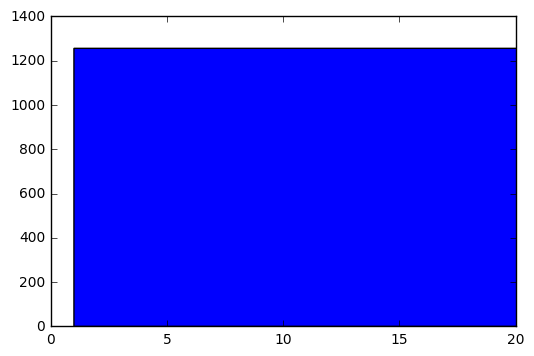

In [25]:
plt.hist(counter.values(), bins=100)
#plt.yscale('log')
axes = plt.gca()
axes.set_xlim([0,20])
#axes.set_ylim([ymin,ymax])

In [ ]:
content = {'url': selected_title_urls,
               'titles': titles,
               'pageViw': selected_title_pageView,
               'token_dict': token_dict,
               'reverse_token_dict': reverse_token_dict}

In [ ]:
data_path = '/Users/matt.meng/Downloads'
file_name = 'small_articles.json'

In [ ]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
def process_raw_data(data_path, file_name):
    start_time = time.time()
    with open(os.path.join(data_path, file_name), 'r') as input:
        counter = 0
        title_df = pd.DataFrame(columns=['title', 'pageView'])
        for line in input:
            json_doc = json.loads(line)
            #publisher_id = json_doc['pv_publisherId']
            expected_keys = ['pv_title', 'pv_url', 'pv_pageViews']
            if not all([key in json_doc.keys() for key in expected_keys]):
                continue
            title, url, pageView = json_doc['pv_title'], json_doc['pv_url'], json_doc['pv_pageViews']
            if not isEnglish(title):
                continue
            title_df.loc[url] = pd.Series({'title' : title, 'pageView' : pageView})
    title_df.index.name = 'url'
    print 'finished processing all the data using {:.2f} seconds'.format(time.time() - start_time) 
    return title_df

def basic_tokenizer(line, normalize_digits=True):
    line = line.replace("'s", '')
    line = re.sub(r"\'ve", " have ", line)
    line = re.sub(r"can't", "cannot ", line)
    line = re.sub(r"n't", " not ", line)
    line = re.sub(r"I'm", "I am", line)
    line = re.sub(r" m ", " am ", line)
    line = re.sub(r"\'re", " are ", line)
    line = re.sub(r"\'d", " would ", line)
    line = re.sub(r"\'ll", " will ", line)
    line = re.sub(r"\?", " ? ", line)
    line = re.sub(r"!", " ! ", line)
    line = re.sub(r":", " : ", line)
    
    line = re.sub('[,."#%\'()*+/;<=>@\[\]^_{|}~`’”“′‘\\\]', ' ', line)
    line = re.sub('[\n\t ]+', ' ', line)
    words = []
    #_WORD_SPLIT = re.compile(b"([.,!?\"'-<>:;)(])")
    _DIGIT_RE = re.compile(r"\d")
    for token in line.strip().lower().split():
        if not token:
            continue
        if normalize_digits:
            token = re.sub(_DIGIT_RE, b'#', token)
        words.append(token)
    return len(words), ' '.join(words)

_PAD = b"_PAD"
_GO = b"_GO"
_EOS = b"_EOS"
_UNK = b"_UNK"
_START_VOCAB = [_PAD, _GO, _EOS, _UNK]

'''
PAD_ID = 0
GO_ID = 1
EOS_ID = 2
UNK_ID = 3
'''

TOKEN_DICT = {}
REVERSE_TOKEN_DICT = {}
for i in xrange(len(_START_VOCAB)):
    TOKEN_DICT[_START_VOCAB[i]] = i
    REVERSE_TOKEN_DICT[i] = _START_VOCAB[i]


def create_vocab_dict(data, column_name, token_freq_threshold=5, UKN_frac_threshold=0.3):
    vocab_dict = {}
    all_titles = []
    selected_titles = []
    selected_title_urls = []
    selected_title_pageView = []
    bad_titles = []
    for title, url, pageView in zip(data[column_name], data.index, data['pageView']):
        words = []
        for token in title.split(' '):
            words.append(token)
            if token not in vocab_dict:
                vocab_dict[token] = 0
            vocab_dict[token] += 1
        all_titles.append((words, url, pageView))
    print 'total {} tokens are ideintified...'.format(len(vocab_dict))

    token_dict, reverse_token_dict = TOKEN_DICT.copy(), REVERSE_TOKEN_DICT.copy()
    UKN_index = len(token_dict) - 1
    unique_counts = 0
    sorted_pairs = sorted(vocab_dict.items(), key=lambda x : x[1], reverse=True)
    for i, pair in enumerate(sorted_pairs):
        if pair[1] >= token_freq_threshold:
            unique_counts += 1
            token_dict[pair[0]] = i + 1 + UKN_index
            reverse_token_dict[(i + 1 + UKN_index)] = pair[0]
        else:
            token_dict[pair[0]] = UKN_index
    print 'total {} unique tokens are included in the token dictionary...'.format(unique_counts)            
    
    for i in xrange(len(all_titles)):
        indexed_title = map(token_dict.get, all_titles[i][0])
        UKN_count = sum([elem == UKN_index for elem in indexed_title])
        if (1.*UKN_count/len(indexed_title)) < UKN_frac_threshold:
            selected_titles.append(indexed_title)
            selected_title_urls.append(all_titles[i][1])
            selected_title_pageView.append(all_titles[i][2])
        else:
            bad_titles.append((indexed_title, all_titles[i][1], all_titles[i][2]))
    print 'total {} titles are included...'.format(len(selected_titles))            
    return token_dict, reverse_token_dict, selected_titles, selected_title_urls, selected_title_pageView, bad_titles

In [ ]:
title_df = process_raw_data(data_path, file_name)

print title_df.shape
title_df.head()

In [ ]:
file_name = '/Users/matt.meng/Downloads/title_data.csv'
title_df.to_csv(file_name, index=True)
data = pd.read_csv(file_name, index_col='url')

In [ ]:
print data.shape
data.head()

In [ ]:
# tokenize the titles
data['title_word_counts'], data['processed_title'] = zip(*data['title'].map(basic_tokenizer))
# sort by the title word counts and filter them
sorted_data = data.sort_values(by=['title_word_counts', 'pageView'], ascending=[True, False])
index = (sorted_data['title_word_counts'] >= 4) & (sorted_data['title_word_counts'] <= 15)
filtered_data = sorted_data.loc[index, :]

In [ ]:
token_dict, reverse_token_dict, titles, selected_title_urls, selected_title_pageView, bad_titles = create_vocab_dict(filtered_data, 'processed_title')

In [ ]:
print len(titles), len(selected_title_urls), len(selected_title_pageView)

In [ ]:
#bad_titles

In [ ]:
pickle_file = 'processed_title_data.pkl'

content = {'url' : selected_title_urls, 
           'titles' : titles, 
           'pageViw' : selected_title_pageView,
           'token_dict' : token_dict,
           'reverse_token_dict' : reverse_token_dict}

with open(pickle_file, 'wb') as handle:
    cPickle.dump(content, handle, protocol=cPickle.HIGHEST_PROTOCOL)